In [ ]:
!pip install joblib matplotlib numpy optuna pandas lightgbm xgboost catboost pytorch-tabnet scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvi

In [ ]:
import json
from functools import partial
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import random
import torch

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, plot_importance

RANDOM_SEED = 67


In [ ]:
ARTIFACT_ROOT = Path("artifacts")


def ensure_dir(path: Path) -> Path:
    path.mkdir(parents=True, exist_ok=True)
    return path


def reshape_for_meta(array: np.ndarray) -> np.ndarray:
    array = np.asarray(array)
    if array.ndim == 1:
        return array.reshape(-1, 1)
    return array


def persist_model(model, destination: Path, model_name: str) -> Path:
    ensure_dir(destination.parent)
    if model_name == "lightgbm":
        file_path = destination.with_suffix(".txt")
        model.save_model(str(file_path))
    elif model_name == "catboost":
        file_path = destination.with_suffix(".cbm")
        model.save_model(str(file_path))
    elif model_name == "xgboost":
        file_path = destination.with_suffix(".json")
        model.save_model(str(file_path))
    elif model_name == "tabnet":
        base_path = str(destination)
        if base_path.endswith(".zip"):
            base_path = base_path[:-4]
        model.save_model(base_path)
        file_path = Path(f"{base_path}.zip")
    else:
        file_path = destination.with_suffix(".pkl")
        with open(file_path, "wb") as fp:
            pickle.dump(model, fp)
    return file_path


def lightgbm_predict_proba(model: lgb.Booster, data):
    best_iter = model.best_iteration or model.current_iteration()
    return model.predict(data, num_iteration=best_iter)


def compute_fold_sample_weight(y_values):
    return compute_sample_weight(class_weight="balanced", y=y_values)


In [ ]:
def train_catboost(X_train, X_val, y_train, y_val, params, fold, sample_weight=None):
    model_params = {**params}
    model_params.setdefault("loss_function", "MultiClass")
    model_params.setdefault("eval_metric", "MultiClass")
    if "task_type" not in model_params:
        model_params["task_type"] = "CPU"
    if model_params.get("task_type") == "GPU" and "devices" not in model_params:
        model_params["devices"] = "0"
    model_params.setdefault("verbose", 0)
    model_params["random_state"] = RANDOM_SEED + fold

    train_pool = Pool(X_train, y_train, weight=sample_weight)
    val_pool = Pool(X_val, y_val)

    model = CatBoostClassifier(**model_params)
    model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=20,
        use_best_model=True,
        verbose=False,
    )

    val_proba = model.predict_proba(X_val)
    val_preds = np.argmax(val_proba, axis=1)
    accuracy = accuracy_score(y_val, val_preds)

    return model, val_proba, accuracy


In [ ]:
def train_lgb(X_train, X_val, y_train, y_val, params, fold, sample_weight=None, num_classes=3):
    model_params = {**params}
    model_params.setdefault("objective", "multiclass")
    model_params.setdefault("num_class", num_classes)
    model_params.setdefault("metric", "multi_logloss")
    model_params.setdefault("verbose", -1)
    model_params["seed"] = RANDOM_SEED + fold

    train_data = lgb.Dataset(X_train, label=y_train, weight=sample_weight)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        model_params,
        train_data,
        num_boost_round=200,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
    )

    val_proba = lightgbm_predict_proba(model, X_val)
    val_preds = np.argmax(val_proba, axis=1)
    accuracy = accuracy_score(y_val, val_preds)

    return model, val_proba, accuracy


In [ ]:
def train_xgb(X_train, X_val, y_train, y_val, params, fold, sample_weight=None, num_classes=3):
    model_params = {**params}
    model_params.setdefault("objective", "multi:softprob")
    model_params.setdefault("num_class", num_classes)
    model_params.setdefault("eval_metric", "mlogloss")
    model_params.setdefault("verbosity", 0)
    model_params["random_state"] = RANDOM_SEED + fold
    model_params["use_label_encoder"] = False
    model_params["early_stopping_rounds"] = 20

    model = XGBClassifier(**model_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        sample_weight=sample_weight,
        verbose=False,
    )

    val_proba = model.predict_proba(X_val)
    val_preds = np.argmax(val_proba, axis=1)
    accuracy = accuracy_score(y_val, val_preds)

    return model, val_proba, accuracy


In [ ]:
def train_tabnet(X_train, X_val, y_train, y_val, params, fold, sample_weight=None):
    model_params = params.copy()
    lr = model_params.pop("lr", 0.01)

    model_params["optimizer_fn"] = torch.optim.AdamW
    model_params["optimizer_params"] = dict(lr=lr)
    model_params.setdefault("verbose", 0)

    model = TabNetClassifier(**model_params)

    model.fit(
        X_train.values,
        y_train,
        eval_set=[(X_val.values, y_val)],
        eval_name=["valid"],
        eval_metric=["logloss"],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        weights=sample_weight,
        from_unsupervised=None,
    )

    val_proba = model.predict_proba(X_val.values)
    val_pred = np.argmax(val_proba, axis=1)
    accuracy = accuracy_score(y_val, val_pred)

    return model, val_proba, accuracy


In [ ]:
def objective_catboost(trial, X, y, n_splits=5, random_seed=RANDOM_SEED):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "task_type": trial.suggest_categorical("task_type", ["CPU", "GPU"]),
        "loss_function": "MultiClass",
        "eval_metric": "MultiClass",
        "random_seed": random_seed,
        "verbose": 0,
    }
    if params["task_type"] == "GPU":
        params["devices"] = "0"

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    accuracies = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        train_weights = compute_fold_sample_weight(y_train)

        model = CatBoostClassifier(**params)
        model.fit(
            X_train,
            y_train,
            sample_weight=train_weights,
            eval_set=(X_val, y_val),
            early_stopping_rounds=20,
            verbose=False,
        )
        preds = model.predict(X_val)
        accuracies.append(accuracy_score(y_val, preds))

    return float(np.mean(accuracies))


In [ ]:
def objective_lgb(trial, X, y, num_classes, n_splits=5, random_seed=RANDOM_SEED):
    params = {
        "objective": "multiclass",
        "num_class": num_classes,
        "metric": "multi_logloss",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "max_depth": trial.suggest_int("max_depth", -1, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "verbose": -1,
        "seed": random_seed,
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    accuracies = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        train_weights = compute_fold_sample_weight(y_train)

        train_data = lgb.Dataset(X_train, label=y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
        )

        preds = np.argmax(lightgbm_predict_proba(model, X_val), axis=1)
        accuracies.append(accuracy_score(y_val, preds))

    return float(np.mean(accuracies))


In [ ]:
def objective_xgb(trial, X, y, num_classes, n_splits=5, random_seed=RANDOM_SEED):
    params = {
        "objective": "multi:softprob",
        "num_class": num_classes,
        "eval_metric": "mlogloss",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "random_state": random_seed,
        "verbosity": 0,
        "use_label_encoder": False,
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    accuracies = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        train_weights = compute_fold_sample_weight(y_train)

        model = XGBClassifier(**params)
        model.fit(
            X_train,
            y_train,
            sample_weight=train_weights,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=20,
            verbose=False,
        )
        preds = model.predict(X_val)
        accuracies.append(accuracy_score(y_val, preds))

    return float(np.mean(accuracies))


In [ ]:
def objective_tabnet(trial, X, y, n_splits=5, random_seed=42):
    optimizer_name = trial.suggest_categorical("optimizer_fn", ["adam", "adamw"])

    optimizer_map = {
        "adam": torch.optim.Adam,
        "adamw": torch.optim.AdamW,
    }

    params = {
        "n_d": trial.suggest_int("n_d", 8, 64, step=8),
        "n_a": trial.suggest_int("n_a", 8, 64, step=8),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0, step=0.1),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True),
        "optimizer_fn": optimizer_map[optimizer_name],
        "optimizer_params": {"lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True)},
        "momentum": trial.suggest_float("momentum", 0.01, 0.4),
        "seed": random_seed,
        "verbose": 0,
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    accuracies = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        train_weights = compute_fold_sample_weight(y_train)

        model = TabNetClassifier(**params)

        model.fit(
            X_train.values,
            y_train.values,
            eval_set=[(X_val.values, y_val.values)],
            eval_metric=["accuracy"],
            max_epochs=200,
            patience=2,
            batch_size=1024,
            virtual_batch_size=128,
            weights=train_weights,
        )

        preds = model.predict(X_val.values)
        accuracies.append(accuracy_score(y_val, preds))

    return float(np.mean(accuracies))


In [ ]:
def run_stacking_pipeline(
    X,
    y,
    *,
    test_size=0.2,
    n_trials=30,
    base_cv_splits=10,
    optuna_cv_splits=5,
    artifact_root: Path = ARTIFACT_ROOT,
    random_seed: int = RANDOM_SEED,
):
    if not isinstance(X, pd.DataFrame):
        X_df = pd.DataFrame(X)
    else:
        X_df = X.copy()

    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("y must be a 1-D vector.")
        y_series = y.iloc[:, 0].copy()
    elif isinstance(y, pd.Series):
        y_series = y.copy()
    else:
        y_series = pd.Series(y)

    if X_df.shape[0] != len(y_series):
        raise ValueError("X and y must have the same number of rows.")
    if len(np.unique(y_series)) < 2:
        raise ValueError("y must contain at least two classes.")

    np.random.seed(random_seed)
    artifact_root = ensure_dir(Path(artifact_root))

    X_train, X_test, y_train, y_test = train_test_split(
        X_df,
        y_series,
        test_size=test_size,
        stratify=y_series,
        random_state=random_seed,
    )

    num_classes = len(np.unique(y_train))

    objective_wrappers = {
        "catboost": partial(
            objective_catboost,
            X=X_train,
            y=y_train,
            n_splits=optuna_cv_splits,
            random_seed=random_seed,
        ),
        "lightgbm": partial(
            objective_lgb,
            X=X_train,
            y=y_train,
            num_classes=num_classes,
            n_splits=optuna_cv_splits,
            random_seed=random_seed,
        ),
        "xgboost": partial(
            objective_xgb,
            X=X_train,
            y=y_train,
            num_classes=num_classes,
            n_splits=optuna_cv_splits,
            random_seed=random_seed,
        ),
        "tabnet": partial(
            objective_tabnet,
            X=X_train,
            y=y_train,
            n_splits=optuna_cv_splits,
            random_seed=random_seed,
        ),
    }

    best_params = {}
    for model_name, objective_fn in objective_wrappers.items():
        study = optuna.create_study(direction="maximize")
        study.optimize(objective_fn, n_trials=n_trials)
        best_params[model_name] = study.best_params
        print(f"{model_name.title()} best params: {study.best_params}")

    with open(artifact_root / "best_params.json", "w", encoding="utf-8") as fp:
        json.dump(best_params, fp, indent=2)

    skf = StratifiedKFold(n_splits=base_cv_splits, shuffle=True, random_state=random_seed)

    oof_predictions = {
        "catboost": np.zeros((len(y_train), num_classes)),
        "lightgbm": np.zeros((len(y_train), num_classes)),
        "xgboost": np.zeros((len(y_train), num_classes)),
        "tabnet": np.zeros((len(y_train), num_classes)),
    }
    test_predictions = {
        "catboost": np.zeros((len(y_test), num_classes)),
        "lightgbm": np.zeros((len(y_test), num_classes)),
        "xgboost": np.zeros((len(y_test), num_classes)),
        "tabnet": np.zeros((len(y_test), num_classes)),
    }
    fold_accuracies = {model: [] for model in oof_predictions}
    saved_model_paths = {model: [] for model in oof_predictions}

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        train_weights = compute_fold_sample_weight(y_tr)

        cb_model, cb_val_proba, cb_acc = train_catboost(
            X_tr,
            X_val,
            y_tr,
            y_val,
            params=best_params["catboost"],
            fold=fold,
            sample_weight=train_weights,
        )
        oof_predictions["catboost"][val_idx] = cb_val_proba
        test_predictions["catboost"] += cb_model.predict_proba(X_test)
        fold_accuracies["catboost"].append(cb_acc)
        saved_model_paths["catboost"].append(
            str(persist_model(cb_model, artifact_root / "catboost" / f"fold_{fold}", "catboost"))
        )

        lgb_model, lgb_val_proba, lgb_acc = train_lgb(
            X_tr,
            X_val,
            y_tr,
            y_val,
            params=best_params["lightgbm"],
            fold=fold,
            sample_weight=train_weights,
            num_classes=num_classes,
        )
        oof_predictions["lightgbm"][val_idx] = lgb_val_proba
        test_predictions["lightgbm"] += lightgbm_predict_proba(lgb_model, X_test)
        fold_accuracies["lightgbm"].append(lgb_acc)
        saved_model_paths["lightgbm"].append(
            str(persist_model(lgb_model, artifact_root / "lightgbm" / f"fold_{fold}", "lightgbm"))
        )

        xgb_model, xgb_val_proba, xgb_acc = train_xgb(
            X_tr,
            X_val,
            y_tr,
            y_val,
            params=best_params["xgboost"],
            fold=fold,
            sample_weight=train_weights,
            num_classes=num_classes,
        )
        oof_predictions["xgboost"][val_idx] = xgb_val_proba
        test_predictions["xgboost"] += xgb_model.predict_proba(X_test)
        fold_accuracies["xgboost"].append(xgb_acc)
        saved_model_paths["xgboost"].append(
            str(persist_model(xgb_model, artifact_root / "xgboost" / f"fold_{fold}", "xgboost"))
        )

        tabnet_model, tabnet_val_proba, tabnet_acc = train_tabnet(
            X_tr,
            X_val,
            y_tr,
            y_val,
            params=best_params["tabnet"],
            fold=fold,
            sample_weight=train_weights,
        )
        oof_predictions["tabnet"][val_idx] = tabnet_val_proba
        test_predictions["tabnet"] += tabnet_model.predict_proba(X_test.values)
        fold_accuracies["tabnet"].append(tabnet_acc)
        saved_model_paths["tabnet"].append(
            str(persist_model(tabnet_model, artifact_root / "tabnet" / f"fold_{fold}", "tabnet"))
        )

        print(f"Fold {fold} complete.")

    for model_name in test_predictions:
        test_predictions[model_name] /= base_cv_splits

    meta_features_train = np.hstack([reshape_for_meta(oof_predictions[name]) for name in oof_predictions])
    meta_features_test = np.hstack([reshape_for_meta(test_predictions[name]) for name in test_predictions])

    meta_model = LogisticRegressionCV(
        cv=base_cv_splits,
        multi_class="multinomial",
        max_iter=1000,
        class_weight="balanced",
        random_state=random_seed,
    )
    meta_model.fit(meta_features_train, y_train)

    meta_train_preds = meta_model.predict(meta_features_train)
    meta_train_acc = accuracy_score(y_train, meta_train_preds)

    meta_test_preds = meta_model.predict(meta_features_test)
    meta_test_acc = accuracy_score(y_test, meta_test_preds)
    meta_test_proba = meta_model.predict_proba(meta_features_test)
    meta_report = classification_report(y_test, meta_test_preds, digits=4)

    meta_model_path = artifact_root / "meta_model.joblib"
    joblib.dump(meta_model, meta_model_path)

    predictions_df = pd.DataFrame(
        {
            "y_true": y_test.values,
            "y_pred": meta_test_preds,
        }
    )
    predictions_path = artifact_root / "meta_model_test_predictions.csv"
    predictions_df.to_csv(predictions_path, index=False)

    np.save(artifact_root / "meta_features_train.npy", meta_features_train)
    np.save(artifact_root / "meta_features_test.npy", meta_features_test)
    np.save(artifact_root / "meta_test_proba.npy", meta_test_proba)

    summary = {
        "best_params": best_params,
        "fold_metrics": {
            name: {
                "mean_accuracy": float(np.mean(scores)),
                "std_accuracy": float(np.std(scores)),
            }
            for name, scores in fold_accuracies.items()
        },
        "meta_train_accuracy": float(meta_train_acc),
        "meta_test_accuracy": float(meta_test_acc),
        "classification_report": meta_report,
        "saved_models": saved_model_paths,
        "meta_model_path": str(meta_model_path),
        "test_predictions_path": str(predictions_path),
    }

    return summary


In [ ]:
data_path = Path("/kaggle/input/nasa-dataset-tryhard/combined_imputed_values.csv")

if data_path.exists():
    df = pd.read_csv(data_path)
    if "disposition" not in df.columns:
        raise KeyError("Column 'disposition' is missing from the dataset.")
    X = df.drop(columns=["disposition"])
    y = df["disposition"]
    print(f"Loaded dataset with shape {df.shape}.")
else:
    print("Dataset 'combined_imputed_values.csv' not found. Define X and y manually.")


Loaded dataset with shape (16707, 11).


In [ ]:
if "X" in globals() and "y" in globals():
    le = LabelEncoder()
    y_fixed = le.fit_transform(y)

    pipeline_results = run_stacking_pipeline(
        X,
        y_fixed,
        test_size=0.2,
        n_trials=30,
        base_cv_splits=10,
        optuna_cv_splits=5,
        artifact_root=ARTIFACT_ROOT,
        random_seed=RANDOM_SEED,
    )
    pipeline_results
else:
    print("Define X (features) and y (target) before running the stacking pipeline.")


[I 2025-10-05 11:25:52,549] A new study created in memory with name: no-name-f0de4d7e-e51e-4f1d-aba7-2c668f68e483
[I 2025-10-05 11:26:48,239] Trial 0 finished with value: 0.6614291058735503 and parameters: {'iterations': 217, 'depth': 10, 'learning_rate': 0.0016083788090401577, 'l2_leaf_reg': 6.971160211362632, 'task_type': 'CPU'}. Best is trial 0 with value: 0.6614291058735503.
[I 2025-10-05 11:27:09,785] Trial 1 finished with value: 0.7014590347923682 and parameters: {'iterations': 177, 'depth': 4, 'learning_rate': 0.14844655685226354, 'l2_leaf_reg': 3.127496162207505, 'task_type': 'GPU'}. Best is trial 1 with value: 0.7014590347923682.
[I 2025-10-05 11:27:13,512] Trial 2 finished with value: 0.6439955106621774 and parameters: {'iterations': 151, 'depth': 5, 'learning_rate': 0.0011846124990474549, 'l2_leaf_reg': 2.5244599550898803, 'task_type': 'CPU'}. Best is trial 1 with value: 0.7014590347923682.
[I 2025-10-05 11:27:19,956] Trial 3 finished with value: 0.6885147774036664 and param

Catboost best params: {'iterations': 449, 'depth': 9, 'learning_rate': 0.07452489162580808, 'l2_leaf_reg': 9.624071790339087, 'task_type': 'CPU'}
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.978074
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.981645
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.97487
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.975656
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:47:35,998] Trial 0 finished with value: 0.6674148896371118 and parameters: {'learning_rate': 0.0027897994056749476, 'num_leaves': 128, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.7534157338565933, 'colsample_bytree': 0.6798808676116319}. Best is trial 0 with value: 0.6674148896371118.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.980139
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.843352
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.851625
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.83698
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.837279
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:47:40,210] Trial 1 finished with value: 0.7000374111485222 and parameters: {'learning_rate': 0.00671633835823325, 'num_leaves': 81, 'max_depth': -1, 'min_child_samples': 44, 'subsample': 0.6270064392231525, 'colsample_bytree': 0.5554441104106529}. Best is trial 1 with value: 0.7000374111485222.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.846885
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.749629
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.760657
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.732886
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.736959
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:47:41,942] Trial 2 finished with value: 0.6808829031051253 and parameters: {'learning_rate': 0.025488325617256665, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9834581528025337, 'colsample_bytree': 0.501543952853927}. Best is trial 1 with value: 0.7000374111485222.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.756032
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.975667
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.97926
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.972948
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.973628
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:47:44,111] Trial 3 finished with value: 0.6754208754208755 and parameters: {'learning_rate': 0.0026624197337240534, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7951570860953145, 'colsample_bytree': 0.6566042436943016}. Best is trial 1 with value: 0.7000374111485222.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.977921
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.667875
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.67575
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.636838
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.649591
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:47:45,733] Trial 4 finished with value: 0.7156752712308269 and parameters: {'learning_rate': 0.21751054058749017, 'num_leaves': 49, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.8384781687570805, 'colsample_bytree': 0.572762313312746}. Best is trial 4 with value: 0.7156752712308269.


Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.667256
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.856082
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.862219
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.848528
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.849708
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:47:47,699] Trial 5 finished with value: 0.6719042274597831 and parameters: {'learning_rate': 0.007293546750763161, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.9790931893659285, 'colsample_bytree': 0.9635446679051796}. Best is trial 4 with value: 0.7156752712308269.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.858868
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.920433
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.925573
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.916386
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.917516
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:47:50,851] Trial 6 finished with value: 0.6823793490460157 and parameters: {'learning_rate': 0.004115274581197572, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 34, 'subsample': 0.8989445791779906, 'colsample_bytree': 0.6910574828932841}. Best is trial 4 with value: 0.7156752712308269.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.9237
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.669823
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.675006
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.641071
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.640192
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:47:52,597] Trial 7 finished with value: 0.7173213617658061 and parameters: {'learning_rate': 0.2126998338160467, 'num_leaves': 39, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9951653568417376, 'colsample_bytree': 0.6532709551451061}. Best is trial 7 with value: 0.7173213617658061.


Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.673703
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.662969
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.677123
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.642133
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.644621
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:47:56,259] Trial 8 finished with value: 0.7135054246165358 and parameters: {'learning_rate': 0.040146102107475407, 'num_leaves': 66, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.9856063624511953, 'colsample_bytree': 0.8182590864029704}. Best is trial 7 with value: 0.7173213617658061.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.672566
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.777339
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.785148
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.769032
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.768624
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:01,180] Trial 9 finished with value: 0.7049756827534606 and parameters: {'learning_rate': 0.009319973980585948, 'num_leaves': 77, 'max_depth': -1, 'min_child_samples': 7, 'subsample': 0.7928842683341906, 'colsample_bytree': 0.8692259614591007}. Best is trial 7 with value: 0.7173213617658061.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.780961
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.66992
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.676717
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.64456
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.647472
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:02,680] Trial 10 finished with value: 0.7131313131313132 and parameters: {'learning_rate': 0.22465217188764536, 'num_leaves': 19, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.5233889479225261, 'colsample_bytree': 0.7928944554495616}. Best is trial 7 with value: 0.7173213617658061.


Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.673121
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.670292
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.680365
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.642089
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.646093
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:04,110] Trial 11 finished with value: 0.7116348671904227 and parameters: {'learning_rate': 0.26614818516171235, 'num_leaves': 43, 'max_depth': 12, 'min_child_samples': 38, 'subsample': 0.8750752480289165, 'colsample_bytree': 0.5910186511915644}. Best is trial 7 with value: 0.7173213617658061.


Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.665805
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.666402
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.672158
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.631796
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.641712
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:06,772] Trial 12 finished with value: 0.7130564908342686 and parameters: {'learning_rate': 0.08561081369042785, 'num_leaves': 45, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.8817891139648931, 'colsample_bytree': 0.6063775495098235}. Best is trial 7 with value: 0.7173213617658061.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.661635
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.674439
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.68597
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.653612
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.655659
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:08,447] Trial 13 finished with value: 0.7099887766554432 and parameters: {'learning_rate': 0.07952065928666363, 'num_leaves': 17, 'max_depth': 15, 'min_child_samples': 48, 'subsample': 0.6130607246907399, 'colsample_bytree': 0.7387283797641221}. Best is trial 7 with value: 0.7173213617658061.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.675527
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04367
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04512
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04266
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04283
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:11,620] Trial 14 finished with value: 0.6877665544332212 and parameters: {'learning_rate': 0.001048960626852366, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.9132941868389239, 'colsample_bytree': 0.5339267784171254}. Best is trial 7 with value: 0.7173213617658061.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04464
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.66217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.675216
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.633496
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.638441
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:14,792] Trial 15 finished with value: 0.7160493827160493 and parameters: {'learning_rate': 0.1198003188220262, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.650380207875193, 'colsample_bytree': 0.6241343802588284}. Best is trial 7 with value: 0.7173213617658061.


Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.666825
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.657405
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's multi_logloss: 0.673501
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.632311
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.628834
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:19,269] Trial 16 finished with value: 0.7170968948746727 and parameters: {'learning_rate': 0.07205422162611128, 'num_leaves': 102, 'max_depth': 13, 'min_child_samples': 38, 'subsample': 0.6591417715967576, 'colsample_bytree': 0.6507508170740849}. Best is trial 7 with value: 0.7173213617658061.


Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.662724
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.670769
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.685798
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.646273
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.651341
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:22,874] Trial 17 finished with value: 0.7109614665170221 and parameters: {'learning_rate': 0.045290664965310014, 'num_leaves': 101, 'max_depth': 8, 'min_child_samples': 38, 'subsample': 0.6834807945564568, 'colsample_bytree': 0.7193942927373695}. Best is trial 7 with value: 0.7173213617658061.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.67511
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.66112
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.675672
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.63585
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.64006
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:25,619] Trial 18 finished with value: 0.7129816685372241 and parameters: {'learning_rate': 0.13559836362773287, 'num_leaves': 99, 'max_depth': 14, 'min_child_samples': 42, 'subsample': 0.5399556701269588, 'colsample_bytree': 0.7815836621286778}. Best is trial 7 with value: 0.7173213617658061.


Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.66357
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.713946
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.728204
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.701864
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.70293
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:28,117] Trial 19 finished with value: 0.704900860456416 and parameters: {'learning_rate': 0.019983704071889936, 'num_leaves': 29, 'max_depth': 13, 'min_child_samples': 49, 'subsample': 0.7090404460101057, 'colsample_bytree': 0.8863701265097166}. Best is trial 7 with value: 0.7173213617658061.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.724189
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.743779
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.753007
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.725253
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.726261
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.748314


[I 2025-10-05 11:48:29,139] Trial 20 finished with value: 0.6774410774410774 and parameters: {'learning_rate': 0.051101501464039266, 'num_leaves': 91, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.5736562531127283, 'colsample_bytree': 0.6774527774670338}. Best is trial 7 with value: 0.7173213617658061.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.659096
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.674082
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.633253
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.645002
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:32,205] Trial 21 finished with value: 0.715001870557426 and parameters: {'learning_rate': 0.12578452250311167, 'num_leaves': 111, 'max_depth': 12, 'min_child_samples': 34, 'subsample': 0.6690457011915492, 'colsample_bytree': 0.6347834105508018}. Best is trial 7 with value: 0.7173213617658061.


Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.662554
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.659268
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.682333
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.630215
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.635602
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:34,994] Trial 22 finished with value: 0.7161990273101384 and parameters: {'learning_rate': 0.1364590345716137, 'num_leaves': 91, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.6201799698287238, 'colsample_bytree': 0.6159937208393965}. Best is trial 7 with value: 0.7173213617658061.


Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.663372
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.66203
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.685276
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.641802
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.645192
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:37,895] Trial 23 finished with value: 0.7175458286569398 and parameters: {'learning_rate': 0.1656477472261641, 'num_leaves': 112, 'max_depth': 15, 'min_child_samples': 13, 'subsample': 0.5848078151470397, 'colsample_bytree': 0.7191904741720603}. Best is trial 23 with value: 0.7175458286569398.


Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.668938
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.668483
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 0.692649
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.651585
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.648215
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:39,969] Trial 24 finished with value: 0.7123082678638234 and parameters: {'learning_rate': 0.28731575281534805, 'num_leaves': 117, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.5777867208639923, 'colsample_bytree': 0.7174413640823359}. Best is trial 23 with value: 0.7175458286569398.


Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.680123
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.666486
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's multi_logloss: 0.676368
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.631038
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.640317
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:45,049] Trial 25 finished with value: 0.7161242050130939 and parameters: {'learning_rate': 0.07196361729795456, 'num_leaves': 119, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.7302415897764825, 'colsample_bytree': 0.7634153530039292}. Best is trial 23 with value: 0.7175458286569398.


Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.66661
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.662538
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.679934
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.635592
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.64202
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:47,865] Trial 26 finished with value: 0.7156752712308269 and parameters: {'learning_rate': 0.17447651678499115, 'num_leaves': 126, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.5693302285115125, 'colsample_bytree': 0.8213313946736842}. Best is trial 23 with value: 0.7175458286569398.


Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.663768
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.663056
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.682218
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.646571
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.651192
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:53,249] Trial 27 finished with value: 0.7161242050130939 and parameters: {'learning_rate': 0.02930895600020883, 'num_leaves': 107, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.6968860778854251, 'colsample_bytree': 0.6563112335540406}. Best is trial 23 with value: 0.7175458286569398.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.674251
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.725353
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.737951
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.715064
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.714734
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:48:58,038] Trial 28 finished with value: 0.7095398428731763 and parameters: {'learning_rate': 0.014447968563766298, 'num_leaves': 88, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.7720901855489246, 'colsample_bytree': 0.7104304348976098}. Best is trial 23 with value: 0.7175458286569398.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.731492
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.656204
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.672636
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.633166
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.632534
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 11:49:03,139] Trial 29 finished with value: 0.716273849607183 and parameters: {'learning_rate': 0.06515194241057828, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.7417786602239076, 'colsample_bytree': 0.6641592525030026}. Best is trial 23 with value: 0.7175458286569398.
[I 2025-10-05 11:49:03,140] A new study created in memory with name: no-name-819de572-c779-4cdb-b1e3-79534012d8b5


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.661779
Lightgbm best params: {'learning_rate': 0.1656477472261641, 'num_leaves': 112, 'max_depth': 15, 'min_child_samples': 13, 'subsample': 0.5848078151470397, 'colsample_bytree': 0.7191904741720603}


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

Xgboost best params: {'learning_rate': 0.06407845536188769, 'max_depth': 10, 'subsample': 0.6367951683747665, 'colsample_bytree': 0.9069731639862751, 'n_estimators': 186}

Early stopping occurred at epoch 3 with best_epoch = 1 and best_val_0_accuracy = 0.45754


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_accuracy = 0.4624


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 3 with best_epoch = 1 and best_val_0_accuracy = 0.4624


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.49532


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_accuracy = 0.46165


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 11:53:11,548] Trial 0 finished with value: 0.467863823419379 and parameters: {'optimizer_fn': 'adam', 'n_d': 8, 'n_a': 8, 'n_steps': 9, 'gamma': 1.4, 'lambda_sparse': 1.2810870558994255e-05, 'lr': 0.0005783072733326021, 'momentum': 0.38209813425243006}. Best is trial 0 with value: 0.467863823419379.



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.63599


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 3 with best_epoch = 1 and best_val_0_accuracy = 0.54059


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.62926


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.60494


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.59035


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 11:54:02,872] Trial 1 finished with value: 0.6002244668911336 and parameters: {'optimizer_fn': 'adamw', 'n_d': 40, 'n_a': 48, 'n_steps': 8, 'gamma': 1.2, 'lambda_sparse': 7.213175402766765e-06, 'lr': 0.0028290314304875814, 'momentum': 0.032308854886727446}. Best is trial 1 with value: 0.6002244668911336.



Early stopping occurred at epoch 22 with best_epoch = 20 and best_val_0_accuracy = 0.50019


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 22 and best_val_0_accuracy = 0.52338


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 34 and best_val_0_accuracy = 0.56117


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 35 and best_val_0_accuracy = 0.56266


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 38 and best_val_0_accuracy = 0.54994


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 11:55:33,860] Trial 2 finished with value: 0.5394687616909839 and parameters: {'optimizer_fn': 'adamw', 'n_d': 16, 'n_a': 24, 'n_steps': 4, 'gamma': 1.7000000000000002, 'lambda_sparse': 2.568311110322362e-05, 'lr': 0.000192518694398692, 'momentum': 0.03860644245563545}. Best is trial 1 with value: 0.6002244668911336.



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.54059


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.55668


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 23 and best_val_0_accuracy = 0.62364


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 29 and best_val_0_accuracy = 0.63038


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 30 and best_val_0_accuracy = 0.61878


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 11:56:44,046] Trial 3 finished with value: 0.5940142162364385 and parameters: {'optimizer_fn': 'adamw', 'n_d': 56, 'n_a': 56, 'n_steps': 4, 'gamma': 1.8, 'lambda_sparse': 0.0002872813374366066, 'lr': 0.00033030011053185825, 'momentum': 0.19320979928006835}. Best is trial 1 with value: 0.6002244668911336.



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.57464


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.56266


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.58249


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 16 and best_val_0_accuracy = 0.58848


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 4 with best_epoch = 2 and best_val_0_accuracy = 0.47811


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 11:57:53,884] Trial 4 finished with value: 0.5572764683875795 and parameters: {'optimizer_fn': 'adamw', 'n_d': 40, 'n_a': 24, 'n_steps': 9, 'gamma': 1.7000000000000002, 'lambda_sparse': 0.0002207048886558005, 'lr': 0.0008927937879613778, 'momentum': 0.042865588265540946}. Best is trial 1 with value: 0.6002244668911336.



Early stopping occurred at epoch 22 with best_epoch = 20 and best_val_0_accuracy = 0.59297


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 25 and best_val_0_accuracy = 0.59596


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 25 and best_val_0_accuracy = 0.61728


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 15 and best_val_0_accuracy = 0.58324


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 19 and best_val_0_accuracy = 0.58661


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 11:58:48,217] Trial 5 finished with value: 0.5952113729891507 and parameters: {'optimizer_fn': 'adamw', 'n_d': 24, 'n_a': 64, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 0.000399780541141052, 'lr': 0.00015808603045837122, 'momentum': 0.24803650733893146}. Best is trial 1 with value: 0.6002244668911336.



Early stopping occurred at epoch 18 with best_epoch = 16 and best_val_0_accuracy = 0.62327


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 22 and best_val_0_accuracy = 0.63374


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 21 and best_val_0_accuracy = 0.64198


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 20 and best_val_0_accuracy = 0.64385


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.63187


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 11:59:38,981] Trial 6 finished with value: 0.6349420127197904 and parameters: {'optimizer_fn': 'adam', 'n_d': 24, 'n_a': 32, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 0.00022558199350427763, 'lr': 0.0005766578290643896, 'momentum': 0.04627368059645296}. Best is trial 6 with value: 0.6349420127197904.



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.57351


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.62851


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.65956


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.60382


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.64609


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:00:18,516] Trial 7 finished with value: 0.6222970445192668 and parameters: {'optimizer_fn': 'adam', 'n_d': 40, 'n_a': 32, 'n_steps': 4, 'gamma': 1.1, 'lambda_sparse': 1.0762839822389636e-06, 'lr': 0.0019296637612810177, 'momentum': 0.38326000072952016}. Best is trial 6 with value: 0.6349420127197904.



Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_accuracy = 0.54433


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.60269


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.6315


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.57127


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.581


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:01:10,201] Trial 8 finished with value: 0.586157875046764 and parameters: {'optimizer_fn': 'adam', 'n_d': 32, 'n_a': 40, 'n_steps': 9, 'gamma': 1.8, 'lambda_sparse': 3.453613365753623e-05, 'lr': 0.004570596194251496, 'momentum': 0.318235080079201}. Best is trial 6 with value: 0.6349420127197904.



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.57538


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.53648


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 15 and best_val_0_accuracy = 0.59783


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.59222


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.53461


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:02:06,699] Trial 9 finished with value: 0.5673026561915451 and parameters: {'optimizer_fn': 'adam', 'n_d': 16, 'n_a': 24, 'n_steps': 6, 'gamma': 2.0, 'lambda_sparse': 1.4189949067682316e-06, 'lr': 0.0016454827807962796, 'momentum': 0.08899752570259087}. Best is trial 6 with value: 0.6349420127197904.



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.61953


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.59259


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_accuracy = 0.62926


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.60045


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.63075


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:02:42,863] Trial 10 finished with value: 0.6145155256266367 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 8, 'n_steps': 6, 'gamma': 1.4, 'lambda_sparse': 0.00011250583270910757, 'lr': 0.009927715598749396, 'momentum': 0.1508102019206427}. Best is trial 6 with value: 0.6349420127197904.



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.64534


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.63861


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.66031


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.60606


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.63562


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:03:17,435] Trial 11 finished with value: 0.6371866816311261 and parameters: {'optimizer_fn': 'adam', 'n_d': 48, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 1.014282845547437e-06, 'lr': 0.0017548777689154827, 'momentum': 0.3962503235363014}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 22 with best_epoch = 20 and best_val_0_accuracy = 0.64534


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.58212


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.60494


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.64235


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.61167


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:03:55,052] Trial 12 finished with value: 0.6172839506172838 and parameters: {'optimizer_fn': 'adam', 'n_d': 56, 'n_a': 40, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0007298897795182789, 'lr': 0.0005235338069109663, 'momentum': 0.27506389286574917}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.58062


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 19 and best_val_0_accuracy = 0.6401


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.63374


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 15 and best_val_0_accuracy = 0.63599


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.63786


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:04:52,705] Trial 13 finished with value: 0.6256640478862702 and parameters: {'optimizer_fn': 'adam', 'n_d': 48, 'n_a': 32, 'n_steps': 5, 'gamma': 1.3, 'lambda_sparse': 3.657784092148186e-06, 'lr': 0.0009916242994469234, 'momentum': 0.13194062383771404}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.61092


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.60456


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.63749


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.62813


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.63075


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:05:42,775] Trial 14 finished with value: 0.6223718668163112 and parameters: {'optimizer_fn': 'adam', 'n_d': 24, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 8.544544810225027e-05, 'lr': 0.00401665658062188, 'momentum': 0.31142671368947883}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 17 with best_epoch = 15 and best_val_0_accuracy = 0.59334


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 21 and best_val_0_accuracy = 0.61691


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.61915


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.6214


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.53685


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:06:24,605] Trial 15 finished with value: 0.5975308641975309 and parameters: {'optimizer_fn': 'adam', 'n_d': 32, 'n_a': 48, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 0.000957715681738231, 'lr': 0.0002931863461517371, 'momentum': 0.19961968633332058}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.59409


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.5997


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.60606


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.61317


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.59708


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:06:59,809] Trial 16 finished with value: 0.602020202020202 and parameters: {'optimizer_fn': 'adam', 'n_d': 48, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 6.248171972341212e-05, 'lr': 0.0016125781536280833, 'momentum': 0.12228888886633374}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.36139


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.36102


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.36177


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.36214


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.36102


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:07:11,488] Trial 17 finished with value: 0.36146651702207266 and parameters: {'optimizer_fn': 'adam', 'n_d': 24, 'n_a': 48, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 2.40989171317117e-06, 'lr': 0.00011150021734869546, 'momentum': 0.33918857541984737}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.59035


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_accuracy = 0.49345


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.5664


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 21 and best_val_0_accuracy = 0.61205


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.52712


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:08:10,171] Trial 18 finished with value: 0.5578750467639356 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 16, 'n_steps': 7, 'gamma': 1.2, 'lambda_sparse': 1.0018633691025844e-05, 'lr': 0.0005856823490706882, 'momentum': 0.26190307661304685}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_accuracy = 0.56304


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.55181


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.64272


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.54807


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 4 with best_epoch = 2 and best_val_0_accuracy = 0.54545


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:08:51,336] Trial 19 finished with value: 0.5702207257762814 and parameters: {'optimizer_fn': 'adam', 'n_d': 48, 'n_a': 40, 'n_steps': 10, 'gamma': 1.3, 'lambda_sparse': 2.4576401501783412e-05, 'lr': 0.005484536659315395, 'momentum': 0.08330385253614832}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.61018


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 19 and best_val_0_accuracy = 0.62252


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.62215


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 21 and best_val_0_accuracy = 0.63562


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 19 and best_val_0_accuracy = 0.6401


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:09:48,094] Trial 20 finished with value: 0.6261129816685373 and parameters: {'optimizer_fn': 'adam', 'n_d': 8, 'n_a': 16, 'n_steps': 4, 'gamma': 1.1, 'lambda_sparse': 0.00014001514251944395, 'lr': 0.002355614114554339, 'momentum': 0.17577514691535456}. Best is trial 11 with value: 0.6371866816311261.



Early stopping occurred at epoch 34 with best_epoch = 32 and best_val_0_accuracy = 0.65021


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 27 and best_val_0_accuracy = 0.6517


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.62701


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 25 and best_val_0_accuracy = 0.64721


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 19 and best_val_0_accuracy = 0.61654


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:10:46,726] Trial 21 finished with value: 0.6385334829779274 and parameters: {'optimizer_fn': 'adam', 'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 0.00016706775141047962, 'lr': 0.0023155057559813676, 'momentum': 0.17947128572980492}. Best is trial 21 with value: 0.6385334829779274.



Early stopping occurred at epoch 18 with best_epoch = 16 and best_val_0_accuracy = 0.60943


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 25 and best_val_0_accuracy = 0.62776


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 27 and best_val_0_accuracy = 0.65544


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.62851


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 23 and best_val_0_accuracy = 0.6214


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:11:42,308] Trial 22 finished with value: 0.6285072951739619 and parameters: {'optimizer_fn': 'adam', 'n_d': 16, 'n_a': 24, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.00048780781624655287, 'lr': 0.0007791639718404806, 'momentum': 0.09636971585777249}. Best is trial 21 with value: 0.6385334829779274.



Early stopping occurred at epoch 22 with best_epoch = 20 and best_val_0_accuracy = 0.63262


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 25 and best_val_0_accuracy = 0.64759


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 19 and best_val_0_accuracy = 0.66554


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 19 and best_val_0_accuracy = 0.63449


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 21 and best_val_0_accuracy = 0.6401


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:12:36,438] Trial 23 finished with value: 0.6440703329592219 and parameters: {'optimizer_fn': 'adam', 'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 0.00019251047365347084, 'lr': 0.0012922815951897887, 'momentum': 0.23165072255889047}. Best is trial 23 with value: 0.6440703329592219.



Early stopping occurred at epoch 28 with best_epoch = 26 and best_val_0_accuracy = 0.61504


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 20 and best_val_0_accuracy = 0.6098


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.61279


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.58997


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.578


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:13:36,304] Trial 24 finished with value: 0.6011223344556679 and parameters: {'optimizer_fn': 'adam', 'n_d': 8, 'n_a': 16, 'n_steps': 4, 'gamma': 1.3, 'lambda_sparse': 5.122084095820457e-05, 'lr': 0.0013079162658483725, 'momentum': 0.22501582893095703}. Best is trial 23 with value: 0.6440703329592219.



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.57426


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.55256


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.60793


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 16 and best_val_0_accuracy = 0.58997


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.39357


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:14:18,218] Trial 25 finished with value: 0.543658810325477 and parameters: {'optimizer_fn': 'adam', 'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.00014475483562947792, 'lr': 0.002890661380551856, 'momentum': 0.2338268535893418}. Best is trial 23 with value: 0.6440703329592219.



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.64422


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.61354


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 16 and best_val_0_accuracy = 0.68051


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.66779


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.61242


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:14:48,928] Trial 26 finished with value: 0.6436962214739992 and parameters: {'optimizer_fn': 'adamw', 'n_d': 16, 'n_a': 24, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 4.36071857887773e-06, 'lr': 0.0074855649650339235, 'momentum': 0.2927371272606285}. Best is trial 23 with value: 0.6440703329592219.



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.63636


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.55668


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.65619


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 4 with best_epoch = 2 and best_val_0_accuracy = 0.59035


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.61392


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:15:11,716] Trial 27 finished with value: 0.6106995884773662 and parameters: {'optimizer_fn': 'adamw', 'n_d': 16, 'n_a': 24, 'n_steps': 4, 'gamma': 1.2, 'lambda_sparse': 4.14045783539195e-06, 'lr': 0.009591466244084667, 'momentum': 0.28781103944929254}. Best is trial 23 with value: 0.6440703329592219.



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.62589


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.60344


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.65619


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.64422


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.57613


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:15:38,448] Trial 28 finished with value: 0.6211747100635989 and parameters: {'optimizer_fn': 'adamw', 'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.4, 'lambda_sparse': 1.2592199068117289e-05, 'lr': 0.006182104584962935, 'momentum': 0.17183596322349753}. Best is trial 23 with value: 0.6440703329592219.



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.58885


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.58399


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 16 and best_val_0_accuracy = 0.60718


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 19 and best_val_0_accuracy = 0.63823


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.54733


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 12:16:38,942] Trial 29 finished with value: 0.5931163486719042 and parameters: {'optimizer_fn': 'adamw', 'n_d': 8, 'n_a': 8, 'n_steps': 6, 'gamma': 1.4, 'lambda_sparse': 1.9015553305581375e-05, 'lr': 0.004048571244108934, 'momentum': 0.34689168224738837}. Best is trial 23 with value: 0.6440703329592219.


Tabnet best params: {'optimizer_fn': 'adam', 'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 0.00019251047365347084, 'lr': 0.0012922815951897887, 'momentum': 0.23165072255889047}
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.65149

Early stopping occurred at epoch 117 with best_epoch = 97 and best_valid_logloss = 0.70884


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_1.zip
Fold 1 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.643541

Early stopping occurred at epoch 178 with best_epoch = 158 and best_valid_logloss = 0.70446


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_2.zip
Fold 2 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.661356

Early stopping occurred at epoch 98 with best_epoch = 78 and best_valid_logloss = 0.72119


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_3.zip
Fold 3 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.683708

Early stopping occurred at epoch 127 with best_epoch = 107 and best_valid_logloss = 0.74865


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_4.zip
Fold 4 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.641152

Early stopping occurred at epoch 95 with best_epoch = 75 and best_valid_logloss = 0.69029


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_5.zip
Fold 5 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.617622

Early stopping occurred at epoch 175 with best_epoch = 155 and best_valid_logloss = 0.65745


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_6.zip
Fold 6 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.630218

Early stopping occurred at epoch 92 with best_epoch = 72 and best_valid_logloss = 0.6879


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_7.zip
Fold 7 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.632979

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_logloss = 0.72911


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_8.zip
Fold 8 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.672265

Early stopping occurred at epoch 132 with best_epoch = 112 and best_valid_logloss = 0.70847


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_9.zip
Fold 9 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.656272
Stop training because you reached max_epochs = 200 with best_epoch = 183 and best_valid_logloss = 0.68611


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_10.zip
Fold 10 complete.


STACKING ENSEMBLE - FINAL RESULTS

✓ Pipeline completed successfully!

--------------------------------------------------------------------------------
META MODEL PERFORMANCE
--------------------------------------------------------------------------------
Train Accuracy: 0.7279
Test Accuracy:  0.7373

Classification Report:
              precision    recall  f1-score   support

           0     0.6596    0.7335    0.6946       803
           1     0.7275    0.7095    0.7184      1332
           2     0.8087    0.7705    0.7891      1207

    accuracy                         0.7373      3342
   macro avg     0.7319    0.7378    0.7340      3342
weighted avg     0.7405    0.7373    0.7382      3342


--------------------------------------------------------------------------------
BASE MODEL CROSS-VALIDATION PERFORMANCE
--------------------------------------------------------------------------------
CATBOOST    : 0.7171 ± 0.0117
LIGHTGBM    : 0.7214 ± 0.0099
XGBOOST     : 0.7253 ± 0.0123


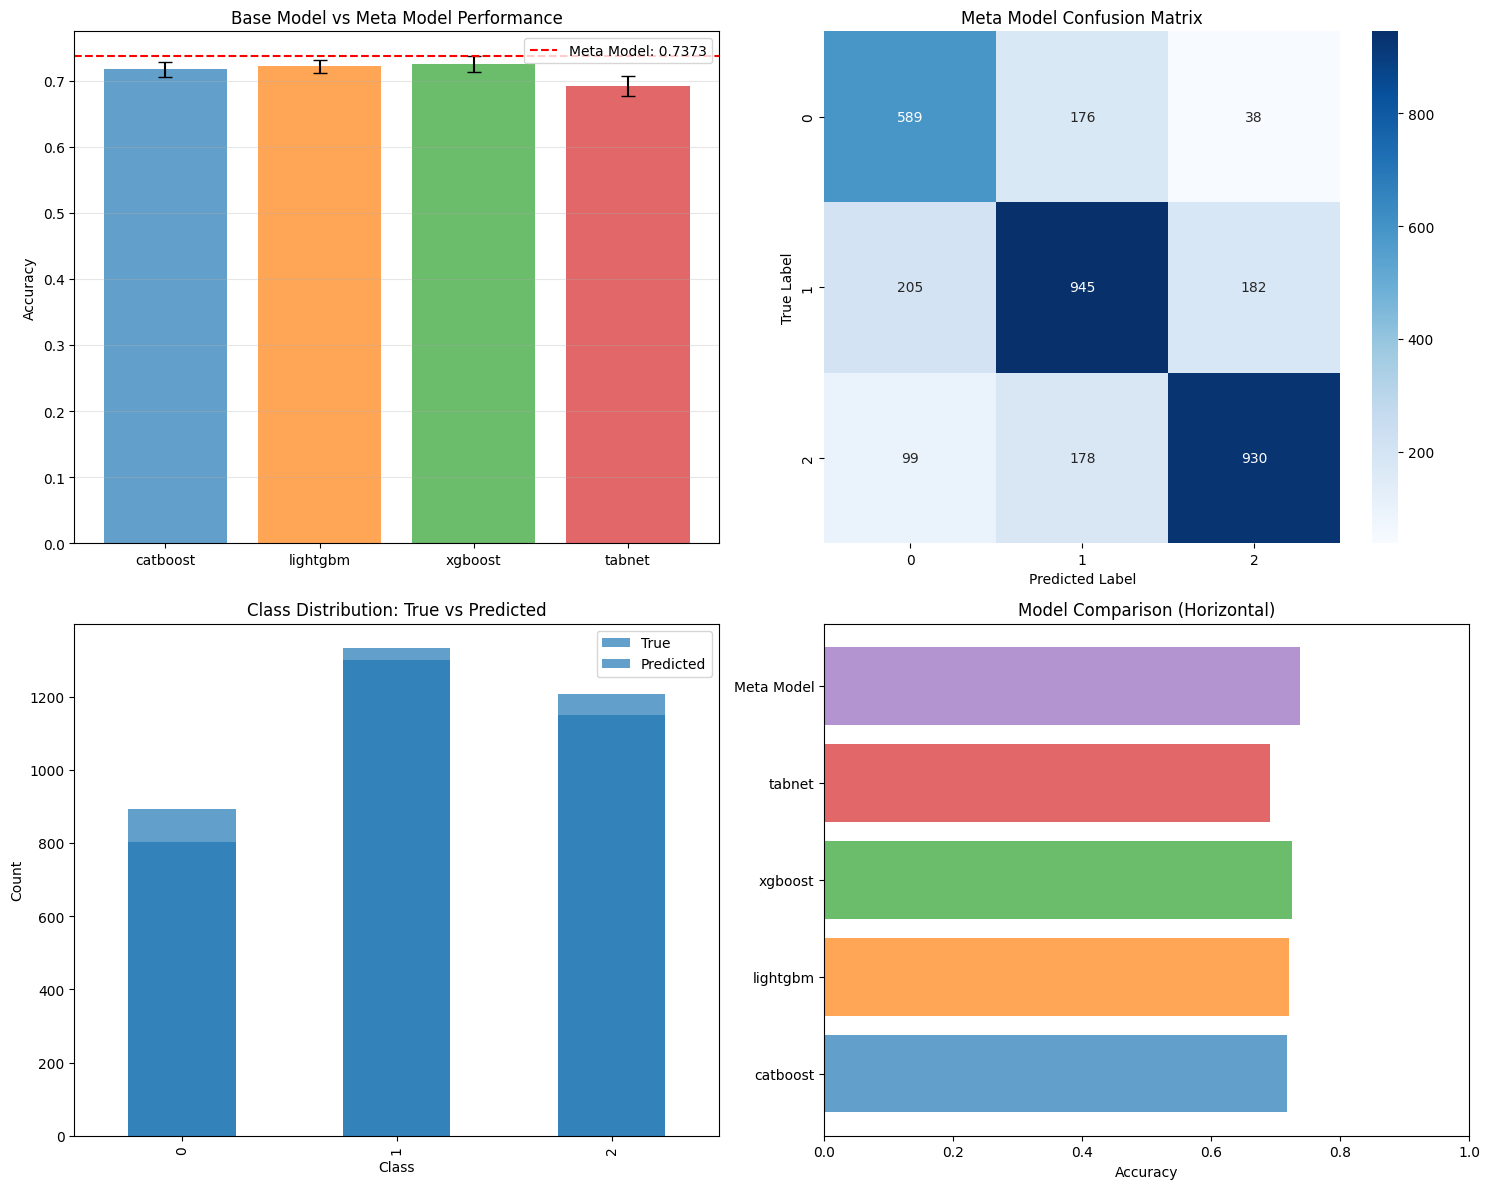


✓ Visualizations saved to artifacts/model_performance_summary.png

SUMMARY

Best Base Model: XGBOOST
  Accuracy: 0.7253 ± 0.0123

Meta Model Improvement: +0.0120 (+1.20%)
✓ Stacking ensemble improved performance!

All results have been saved to the 'artifacts' directory.


In [ ]:
# ============================================================================
# FINAL VERIFICATION AND VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("="*80)
print("STACKING ENSEMBLE - FINAL RESULTS")
print("="*80)

# 1. Check if pipeline ran successfully
if 'pipeline_results' not in globals():
    print("\n ERROR: pipeline_results not found. The training may not have completed.")
    print("Please run the previous cell again.")
else:
    print("\n✓ Pipeline completed successfully!\n")

    # 2. Display Meta Model Performance
    print("-"*80)
    print("META MODEL PERFORMANCE")
    print("-"*80)
    print(f"Train Accuracy: {pipeline_results['meta_train_accuracy']:.4f}")
    print(f"Test Accuracy:  {pipeline_results['meta_test_accuracy']:.4f}")
    print(f"\nClassification Report:\n{pipeline_results['classification_report']}")

    # 3. Display Base Model Performance
    print("\n" + "-"*80)
    print("BASE MODEL CROSS-VALIDATION PERFORMANCE")
    print("-"*80)
    for model_name, metrics in pipeline_results['fold_metrics'].items():
        print(f"{model_name.upper():12s}: {metrics['mean_accuracy']:.4f} ± {metrics['std_accuracy']:.4f}")

    # 4. Verify saved artifacts
    print("\n" + "-"*80)
    print("SAVED ARTIFACTS")
    print("-"*80)
    artifact_root = Path("artifacts")

    files_to_check = [
        artifact_root / "best_params.json",
        artifact_root / "meta_model.joblib",
        artifact_root / "meta_model_test_predictions.csv",
        artifact_root / "meta_features_train.npy",
        artifact_root / "meta_features_test.npy",
        artifact_root / "meta_test_proba.npy",
    ]

    for file_path in files_to_check:
        if file_path.exists():
            print(f"✓ {file_path}")
        else:
            print(f"✗ {file_path} - NOT FOUND")

    # Check model folders
    for model_type in ['catboost', 'lightgbm', 'xgboost', 'tabnet']:
        model_dir = artifact_root / model_type
        if model_dir.exists():
            num_models = len(list(model_dir.glob('fold_*')))
            print(f"✓ {model_type:12s}: {num_models} fold models")
        else:
            print(f"✗ {model_type:12s}: directory not found")

    # 5. Visualizations
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Base Model Accuracy Comparison
    ax1 = axes[0, 0]
    models = list(pipeline_results['fold_metrics'].keys())
    means = [pipeline_results['fold_metrics'][m]['mean_accuracy'] for m in models]
    stds = [pipeline_results['fold_metrics'][m]['std_accuracy'] for m in models]

    ax1.bar(models, means, yerr=stds, capsize=5, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax1.axhline(y=pipeline_results['meta_test_accuracy'], color='red', linestyle='--',
                label=f"Meta Model: {pipeline_results['meta_test_accuracy']:.4f}")
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Base Model vs Meta Model Performance')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Confusion Matrix
    ax2 = axes[0, 1]
    predictions_df = pd.read_csv(artifact_root / "meta_model_test_predictions.csv")
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(predictions_df['y_true'], predictions_df['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Meta Model Confusion Matrix')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')

    # Plot 3: Prediction Distribution
    ax3 = axes[1, 0]
    predictions_df['y_true'].value_counts().sort_index().plot(kind='bar', ax=ax3, alpha=0.7, label='True')
    predictions_df['y_pred'].value_counts().sort_index().plot(kind='bar', ax=ax3, alpha=0.7, label='Predicted')
    ax3.set_title('Class Distribution: True vs Predicted')
    ax3.set_xlabel('Class')
    ax3.set_ylabel('Count')
    ax3.legend()

    # Plot 4: Model Accuracy Distribution
    ax4 = axes[1, 1]
    all_accuracies = []
    model_labels = []
    for model_name in models:
        # This is a simplification - you'd need actual fold-wise accuracies
        mean_acc = pipeline_results['fold_metrics'][model_name]['mean_accuracy']
        std_acc = pipeline_results['fold_metrics'][model_name]['std_accuracy']
        all_accuracies.append(mean_acc)
        model_labels.append(model_name)

    all_accuracies.append(pipeline_results['meta_test_accuracy'])
    model_labels.append('Meta Model')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    ax4.barh(model_labels, all_accuracies, color=colors, alpha=0.7)
    ax4.set_xlabel('Accuracy')
    ax4.set_title('Model Comparison (Horizontal)')
    ax4.set_xlim(0, 1)

    plt.tight_layout()
    plt.savefig(artifact_root / 'model_performance_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Visualizations saved to {artifact_root / 'model_performance_summary.png'}")

    # 6. Summary Statistics
    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)

    best_base_model = max(pipeline_results['fold_metrics'].items(),
                          key=lambda x: x[1]['mean_accuracy'])

    print(f"\nBest Base Model: {best_base_model[0].upper()}")
    print(f"  Accuracy: {best_base_model[1]['mean_accuracy']:.4f} ± {best_base_model[1]['std_accuracy']:.4f}")

    improvement = pipeline_results['meta_test_accuracy'] - best_base_model[1]['mean_accuracy']
    print(f"\nMeta Model Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")

    if improvement > 0:
        print("Stacking ensemble improved performance!")
    else:
        print("Stacking ensemble did not improve over best base model.")

    print("\n" + "="*80)
    print("All results have been saved to the 'artifacts' directory.")
    print("="*80)

In [ ]:
import shutil

shutil.make_archive('artifacts', 'zip', '/kaggle/working/artifacts')

from IPython.display import FileLink
FileLink(r'artifacts.zip')

/kaggle/working/artifacts.zip